# Stellar Classification Dataset - SDSS17

- In astronomy, stellar classification is the classification of stars based on their spectral characteristics. 
- The classification scheme of galaxies, quasars, and stars is one of the most fundamental in astronomy. 
- The early cataloguing of stars and their distribution in the sky has led to the understanding that they make up our own galaxy and, following the distinction that Andromeda was a separate galaxy to our own, numerous galaxies began to be surveyed as more powerful telescopes were built. 
- This datasat aims to classificate stars, galaxies, and quasars based on their spectral characteristics
- For more information, access the [link](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17) to the Kaggle's Dataset.

| Variable | Description|
|:------:|:------:|
| obj_ID | Object Identifier, the unique value that identifies the object in the image catalog used by the CAS|
| alpha  |Right Ascension angle (at J2000 epoch)|
| delta |Declination angle (at J2000 epoch)|
| u |Ultraviolet filter in the photometric system|
| g |Green filter in the photometric system|
| r |Red filter in the photometric system|
| i |Near Infrared filter in the photometric system|
| z | Infrared filter in the photometric system|
| run_ID | Run Number used to identify the specific scan|
| rerun_ID |Rerun Number to specify how the image was processed|
| cam_col |Camera column to identify the scanline within the run|
| field_ID |Field number to identify each field|
| spec_obj_ID | Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)|
| class | Output class|
| redshift | Redshift value based on the increase in wavelength|
| plate | Identifies each plate in SDSSr|
| MJD |Modified Julian Date, used to indicate when a given piece of SDSS data was taken
| fiber_ID | Identifies the fiber that pointed the light at the focal plane in each observation|

## Objectives

Evaluate three different neural networks in order to identify the correct classification for each star.
Models:
- No Hidden Layers;
- One Hidden Layer with 64 neurons;
- Two Hidden Layers with 64 and 32 neurons.

## Imports

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

## Data Cleaning and Feature Engineering

In [7]:
data = pd.read_csv('data/star_classification.csv')
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

This dataset cointains 100000 entries and is divided between 18 columns, which ten having "float64" dtype, seven having int64 as dtype ,and the classification variable (class) having dtype object. There are no null values in this dataset .

In [4]:
data.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


There is a big difference between each variables distribution. So, it's necessary to apply a scaler in order to use a neural network model efficiently. I will also drop the 4 "ID" columns as well.

In [5]:
data_new = data.drop(columns=['obj_ID', 'run_ID', 'rerun_ID', 'spec_obj_ID', 'field_ID', 'fiber_ID'])

<AxesSubplot:>

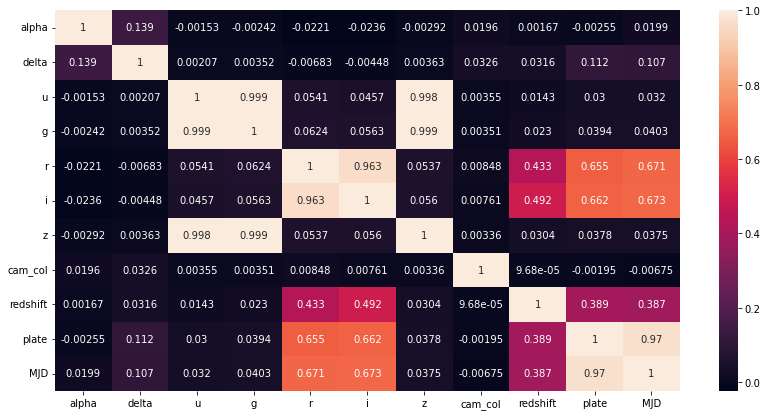

In [6]:
corr_values = data_new.corr()

plt.subplots(figsize = (14,7))
sns.heatmap(corr_values, annot=True, fmt='.3g')

As we can see, there are a large correlation between some filter variables, as between "u" and "g". There is also a high correlation between "plate" and "MID".

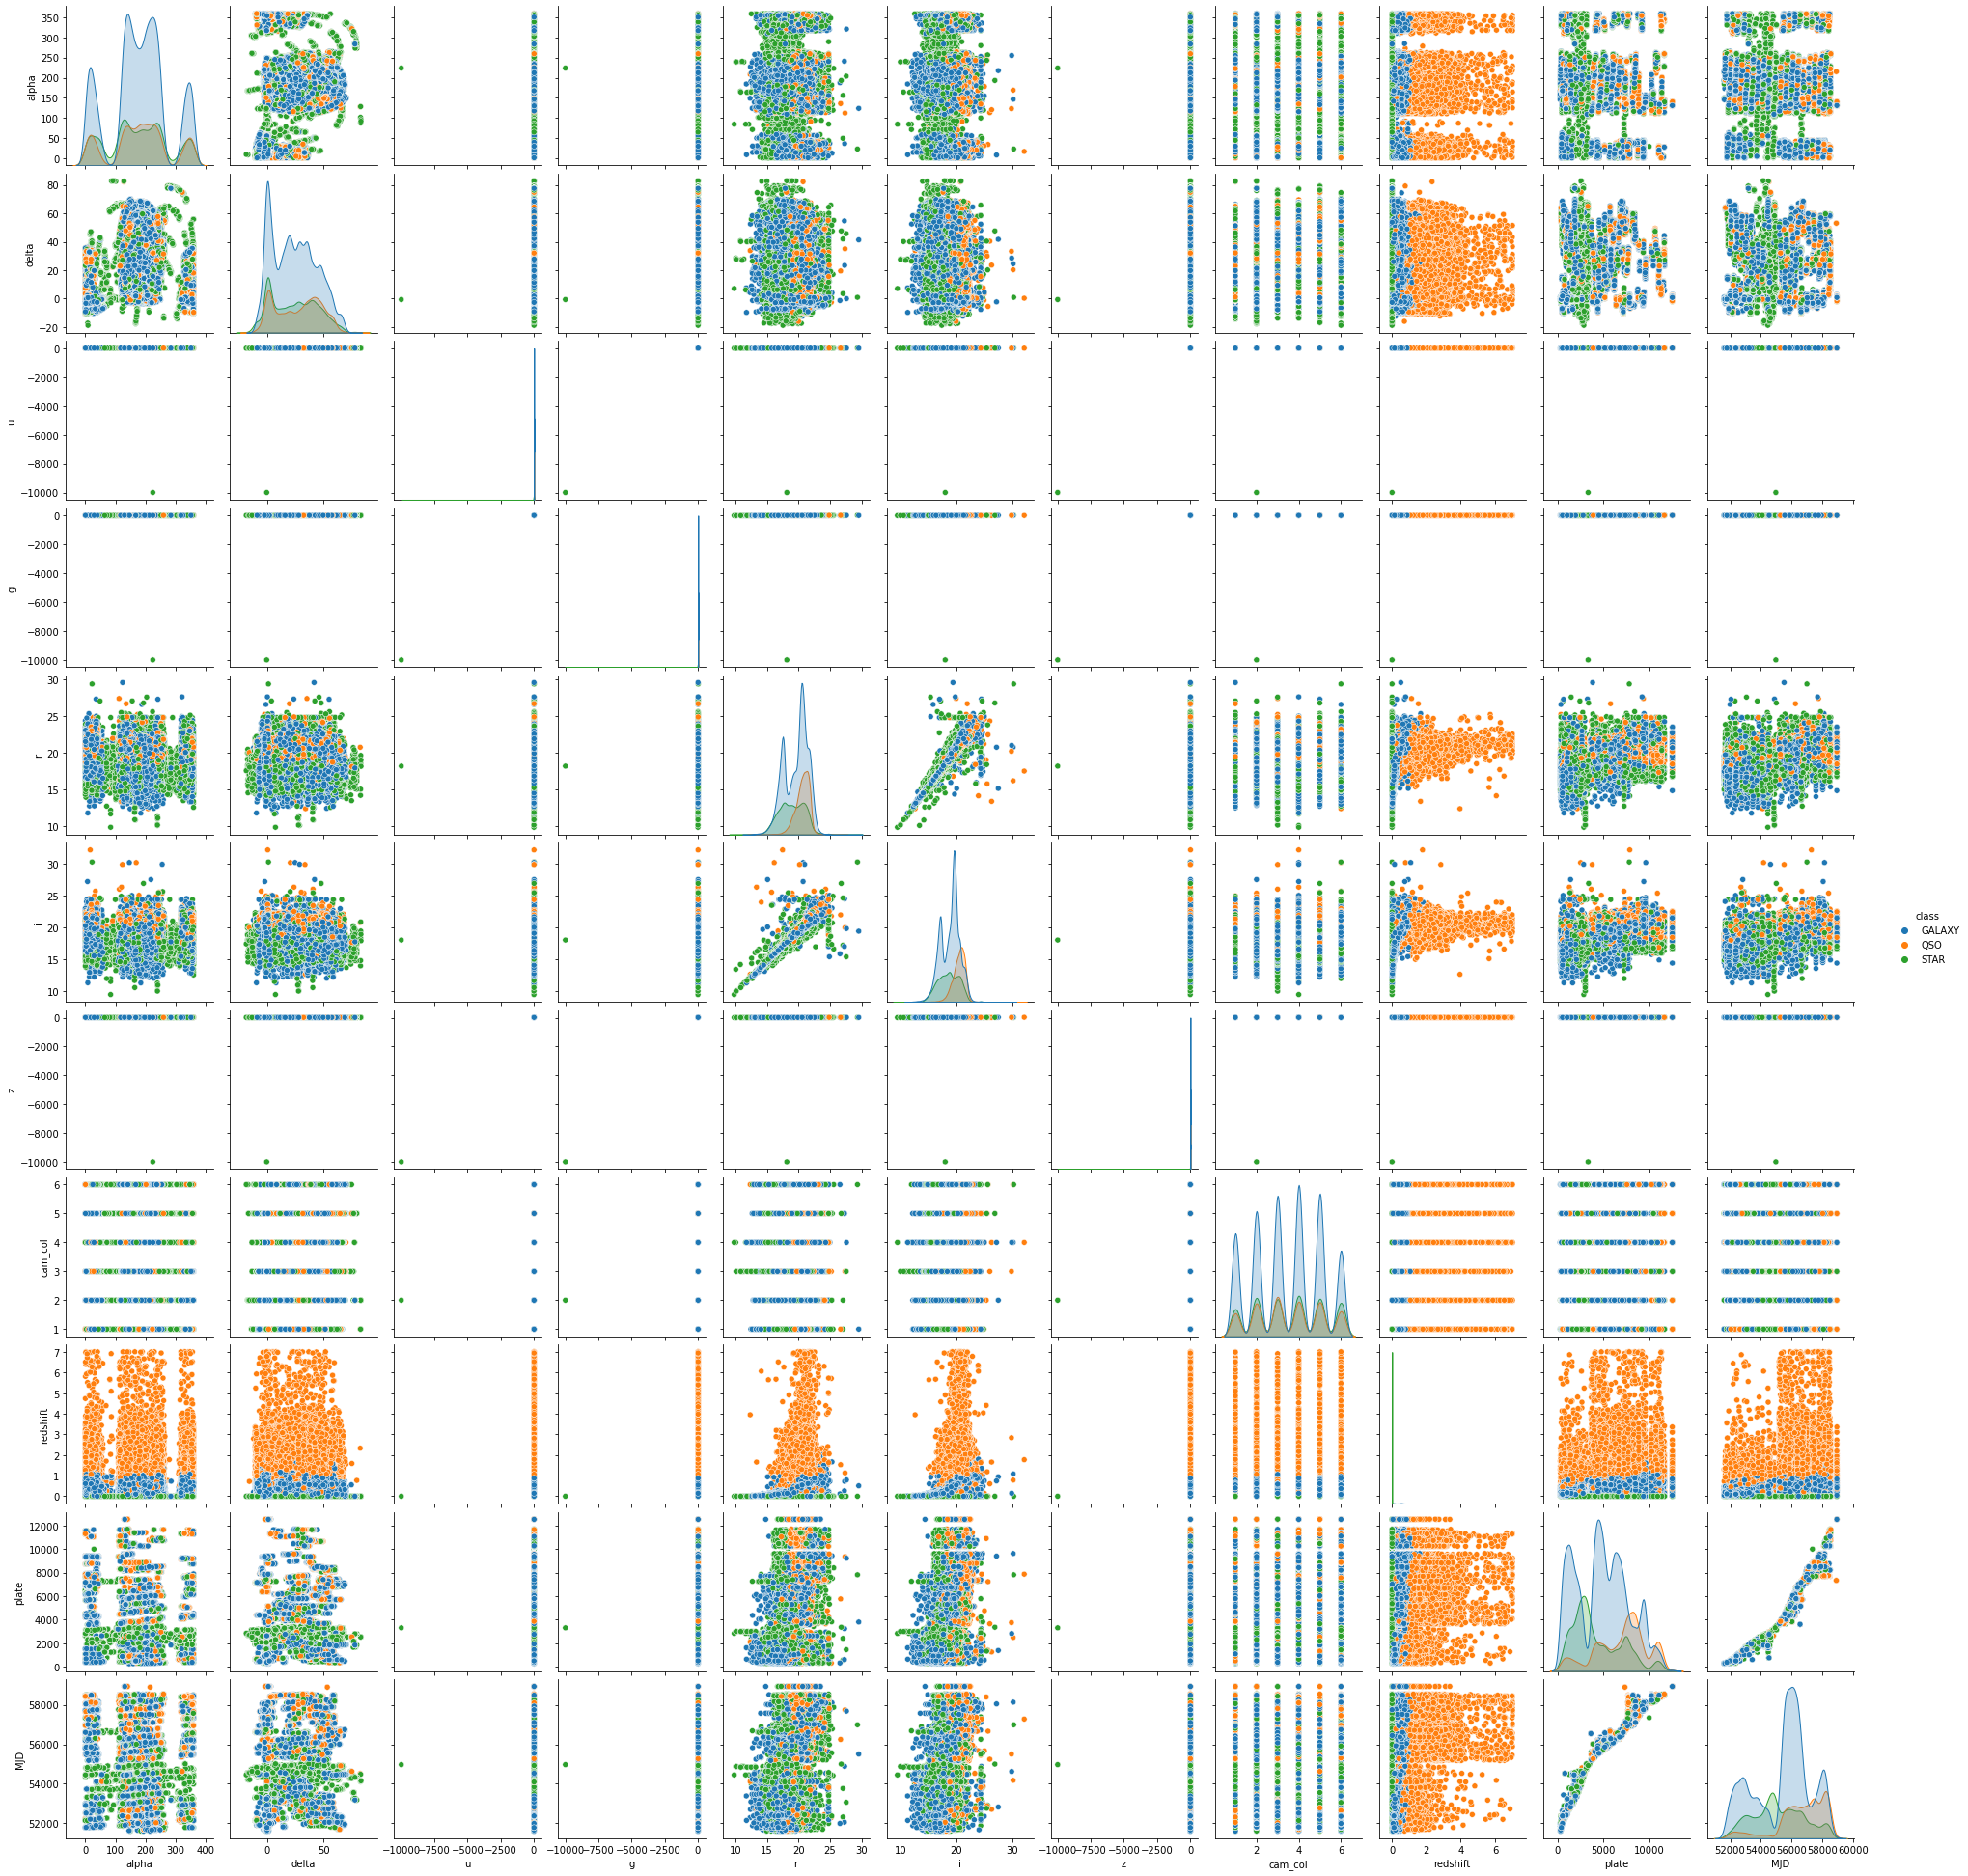

In [138]:
sns.pairplot(data_new, hue='class')

The scatter plots above shows those correlations between variables and the differentiation between classes. Now I wull separate both X and y variables.

In [7]:
X = data_new.drop(columns='class')
y = data_new['class']

In [8]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

For the application of a Classification Model, it is necessary to encode the "class" variable, since it's a multiclassification problem. Then, I will transform the numerical variable to a one hot encoded format.

In [9]:
# Numeric variables
le = LabelEncoder()
y_fit = le.fit_transform(y)

# To categorical
y_cat = to_categorical(y_fit, num_classes=3)
y_cat

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## Summary for Data Cleaning and Feature Engineering

- Dropping all ID columns;
- Standard Scaler used for the features;
- Label Encoder and One Hot Encode used to the target.

## Model Creation

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, random_state=42, stratify=y_cat, test_size=0.25)

In [35]:
tensorflow.keras.backend.clear_session()

In [15]:
callback = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

### Zero Hidden Layers

In [17]:
tensorflow.random.set_seed(42)

model_1 = Sequential([Dense(128, activation='relu'),
                      Dense(3,activation='softmax')])

model_1.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

model_1.history = model_1.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              epochs=20, callbacks=callback)

Epoch 1/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.2953 - accuracy: 0.9100 - val_loss: 0.1748 - val_accuracy: 0.9457
Epoch 2/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1764 - accuracy: 0.9547 - val_loss: 0.1490 - val_accuracy: 0.9562
Epoch 3/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1441 - accuracy: 0.9589 - val_loss: 0.1382 - val_accuracy: 0.9584
Epoch 4/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1291 - accuracy: 0.9617 - val_loss: 0.1345 - val_accuracy: 0.9604
Epoch 5/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1238 - accuracy: 0.9638 - val_loss: 0.1271 - val_accuracy: 0.9614
Epoch 6/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1195 - accuracy: 0.9647 - val_loss: 0.1252 - val_accuracy: 0.9626
Epoch 7/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1162 - accuracy: 0.9660 - val_loss: 0.1242 - val_accuracy:

In [18]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,923
Trainable params: 1,923
Non-trainable params: 0
_________________________________________________________________


In [19]:
def plot_accuracy(model):
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'])

In [20]:
def plot_loss(model):
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(model.history.history['loss'])
    plt.plot(model.history.history['val_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'])

In [21]:
def model_pred(model):
    y_pred = model.predict(X_test).argmax(axis=1)
    y_pred_encoded = to_categorical(y_pred, num_classes=3)
    print(classification_report(y_test, y_pred_encoded))
    
    return y_pred_encoded

In [22]:
def plot_conf_matrix(y_pred):
    _, ax = plt.subplots(figsize=(6,6))
    ax = sns.heatmap(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"})  
    labels = ['False', 'True']
    ax.set_ylabel('Prediction', fontsize=12);
    ax.set_xlabel('Ground Truth', fontsize=12)

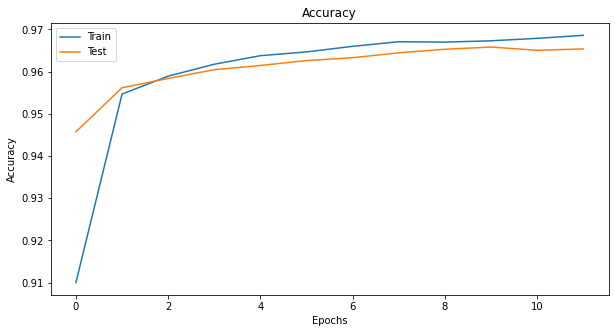

In [23]:
plot_accuracy(model_1)

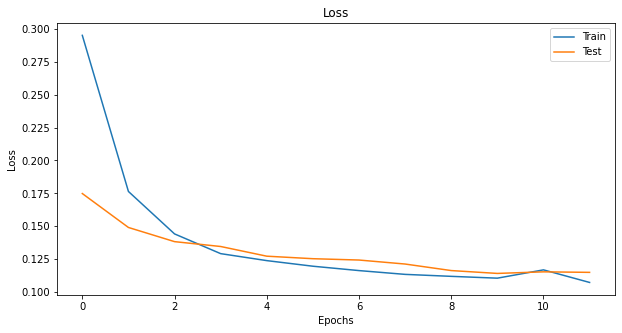

In [24]:
plot_loss(model_1)

In [25]:
model_1_pred = model_pred(model_1)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     14861
           1       0.97      0.90      0.93      4740
           2       0.96      1.00      0.98      5399

   micro avg       0.97      0.97      0.97     25000
   macro avg       0.97      0.96      0.96     25000
weighted avg       0.97      0.97      0.97     25000
 samples avg       0.97      0.97      0.97     25000



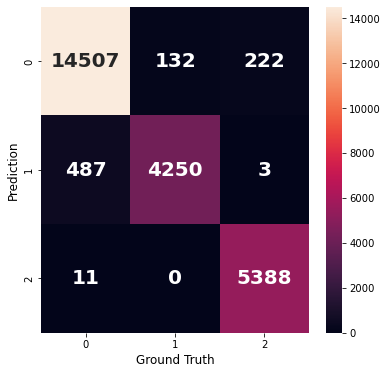

In [26]:
plot_conf_matrix(model_1_pred)

In [42]:
model_1_loss, model_1_acc = model_1.evaluate(X_test,y_test)

782/782 [==============================] - 1s 769us/step - loss: 0.1140 - accuracy: 0.9658


The first model took 12 epochs to achieve the callback tolerance and obtained a 96,58% accuracy.

### One Hidden Layer

In [30]:
tensorflow.random.set_seed(42)

model_2 = Sequential([Dense(128, activation='relu'),
                      Dense(64, activation='relu'),
                      Dense(3,activation='softmax')])

model_2.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

model_2.history = model_2.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              epochs=20, callbacks=callback)

Epoch 1/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.2609 - accuracy: 0.9343 - val_loss: 0.1427 - val_accuracy: 0.9563
Epoch 2/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1350 - accuracy: 0.9596 - val_loss: 0.1281 - val_accuracy: 0.9608
Epoch 3/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1202 - accuracy: 0.9628 - val_loss: 0.1153 - val_accuracy: 0.9647
Epoch 4/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1172 - accuracy: 0.9637 - val_loss: 0.1199 - val_accuracy: 0.9633
Epoch 5/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1126 - accuracy: 0.9656 - val_loss: 0.1182 - val_accuracy: 0.9636


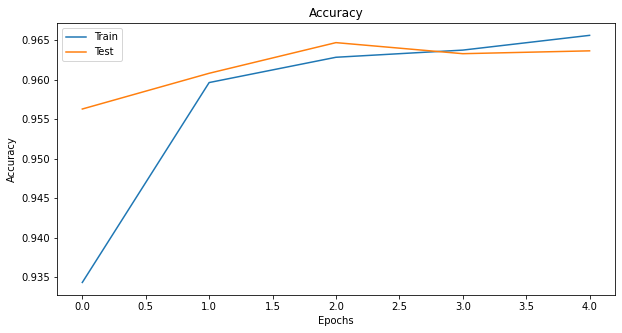

In [31]:
plot_accuracy(model_2)

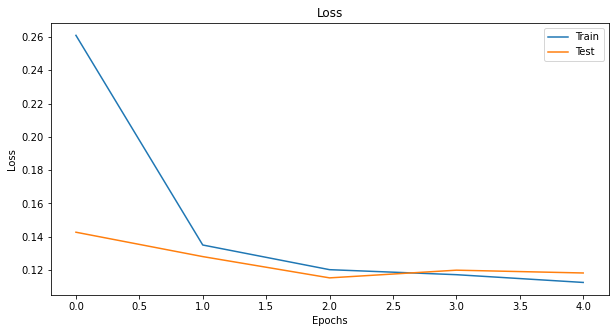

In [32]:
plot_loss(model_2)

In [33]:
model_2_pred = model_pred(model_2)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     14861
           1       0.97      0.90      0.93      4740
           2       0.96      0.99      0.98      5399

   micro avg       0.96      0.96      0.96     25000
   macro avg       0.96      0.96      0.96     25000
weighted avg       0.96      0.96      0.96     25000
 samples avg       0.96      0.96      0.96     25000



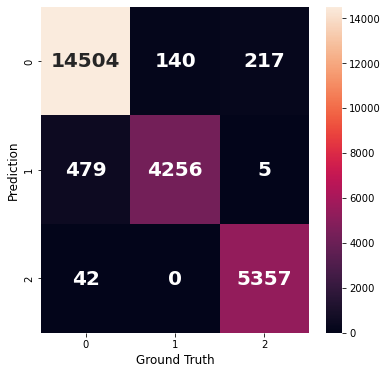

In [34]:
plot_conf_matrix(model_2_pred)

In [43]:
model_2_loss, model_2_acc = model_2.evaluate(X_test,y_test)

782/782 [==============================] - 1s 784us/step - loss: 0.1153 - accuracy: 0.9647


The second model took 5 epochs to achieve the callback tolerance and obtained a 96,47% accuracy.

### Two Hidden Layers

In [37]:
tensorflow.random.set_seed(42)

model_3 = Sequential([Dense(128, activation='relu'),
                      Dense(64, activation='relu'),
                      Dense(32, activation='relu'),
                      Dense(3,activation='softmax')])

model_3.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

model_3.history = model_3.fit(X_train, y_train,
                              validation_data=(X_test, y_test),
                              epochs=20, callbacks=callback)

Epoch 1/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.2367 - accuracy: 0.9341 - val_loss: 0.1404 - val_accuracy: 0.9565
Epoch 2/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1301 - accuracy: 0.9590 - val_loss: 0.1361 - val_accuracy: 0.9552
Epoch 3/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1208 - accuracy: 0.9618 - val_loss: 0.1156 - val_accuracy: 0.9629
Epoch 4/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1184 - accuracy: 0.9626 - val_loss: 0.1231 - val_accuracy: 0.9619
Epoch 5/20
2344/2344 [==============================] - 3s 1ms/step - loss: 0.1127 - accuracy: 0.9653 - val_loss: 0.1197 - val_accuracy: 0.9618


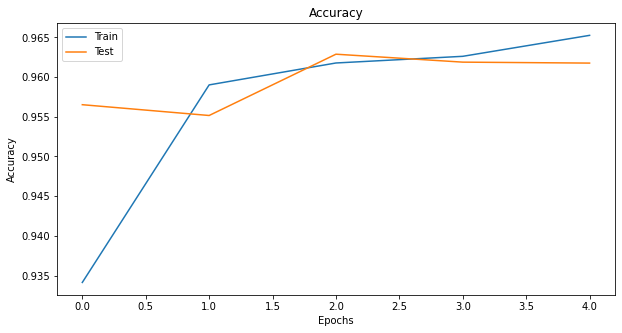

In [38]:
plot_accuracy(model_3)

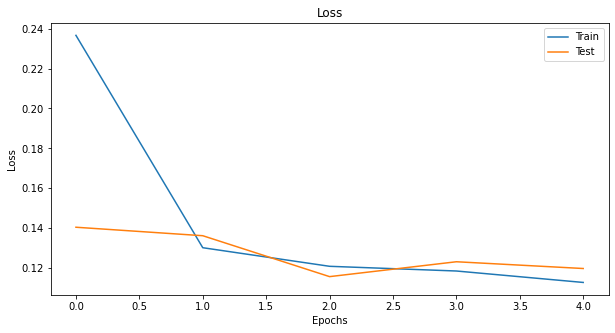

In [39]:
plot_loss(model_3)

In [40]:
model_3_pred = model_pred(model_3)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14861
           1       0.96      0.90      0.93      4740
           2       0.96      0.98      0.97      5399

   micro avg       0.96      0.96      0.96     25000
   macro avg       0.96      0.95      0.96     25000
weighted avg       0.96      0.96      0.96     25000
 samples avg       0.96      0.96      0.96     25000



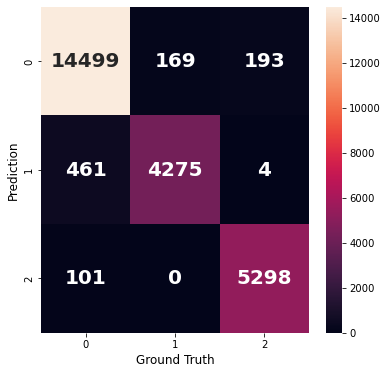

In [41]:
plot_conf_matrix(model_3_pred)

In [44]:
model_3_loss, model_3_acc= model_3.evaluate(X_test,y_test)

782/782 [==============================] - 1s 836us/step - loss: 0.1156 - accuracy: 0.9629


The third model took 5 epochs to achieve the callback tolerance and obtained a 96,29% accuracy.

In [45]:
dict = {'Models': ['Model 1', 'Model 2', 'Model 3'],
        'Accuracy': [model_1_acc, model_2_acc, model_3_acc],
        'Loss': [model_1_loss, model_2_loss, model_3_loss]}

pd.DataFrame(dict).set_index('Models')

,Accuracy,Loss
Models,,
Model 1,0.96580,0.114013
Model 2,0.96468,0.115299
Model 3,0.96288,0.115600


The first model obtained a bigger accuracy and a smaller loss in comparison to the most complex models.

In [48]:
pred = [model_1_pred, model_2_pred, model_3_pred]
true_1 = list()
true_2 = list()
true_3 = list()

for i in pred:
    true_1.append(confusion_matrix(y_test.argmax(axis=1), i.argmax(axis=1))[0,0])
    true_2.append(confusion_matrix(y_test.argmax(axis=1), i.argmax(axis=1))[1,1])
    true_3.append(confusion_matrix(y_test.argmax(axis=1), i.argmax(axis=1))[2,2])

In [50]:
dict = {'Models': ['Model 1', 'Model 2', 'Model 3'],
        'GALAXY': true_1,
        'QSO': true_2,
        'STAR': true_3}

pd.DataFrame(dict).set_index('Models')

,GALAXY,QSO,STAR
Models,,,
Model 1,14507,4250,5388
Model 2,14504,4256,5357
Model 3,14499,4275,5298


The first model was also the better one to classify each class.

## Conclusion

Actions taken in Data Cleaning and Feature Engineering:
- Dropping all ID columns;
- Standard Scaler used for the features;
- Label Encoder and One Hot Encode used to the target.
Model Creation Results:
- First Model took 12 epochs to achieve the callback tolerance;
- Second and Third Models took 5 epochs to achieve the callback tolerance;
- The first model obtained a bigger accuracy and a smaller loss in comparison to the most complex models and was better in classifying each class.
- Therefore, the simplest model was the one that achieved the better performance in this Stellar Classification. 

## Next Steps

For the next steps, I suggest trying different neural networks configuration, perhaps using a smaller number of neurons and trying different sets of features in order to obtain a better result.